In [1]:
import os
import h5py
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nb
from brainspace.datasets import load_conte69
from brainspace.mesh import mesh_elements
from brainspace.utils.parcellation import map_to_labels
from brainstat.mesh.data import mesh_smooth
from numpy import genfromtxt 
import plot_funcs


In [2]:
qc_file = '../data/qualityControl_Bayrak_v03.xlsx'

In [3]:
df = pd.read_excel(qc_file, index_col=0)
df.index = df.index.map(str)
DF = df.copy(deep=True)
subjlist = DF.index

In [4]:
df_file = '../data/tout_group/cortex_corr_indiv.xlsx'

DF = pd.read_excel(df_file, index_col=0)
DF.index = DF.index.map(str)

In [5]:
len(DF) # subjects passing earlier quality control steps in HCP S900

740

In [6]:
DF['SUB'].mean() - 2.5 * DF['SUB'].std()

0.5339926400963126

In [7]:
DF['CA'].mean() - 2.5 * DF['CA'].std()

0.46755916163952005

In [8]:
DF['DG'].mean() - 2.5 * DF['DG'].std()

0.4280198842504976

## similarity of individual-level functional connectivity to the group-level fc

## SUB fc

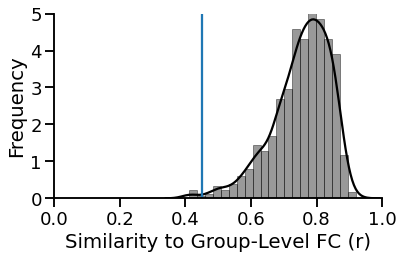

In [9]:
sns.set_context("talk", font_scale=1.1)
ax = sns.distplot(DF['SUB'], 
                  hist_kws=dict(edgecolor="k", linewidth=1),
                  color='k')
sns.despine()
ax.set(xlim=(0,1))
ax.set(ylabel='Frequency')
ax.set(xlabel='Similarity to Group-Level FC (r)')
plt.axvline(0.45, 0, 5)
ax.set(ylim=(0,5))
plt.tight_layout()


## CA fc

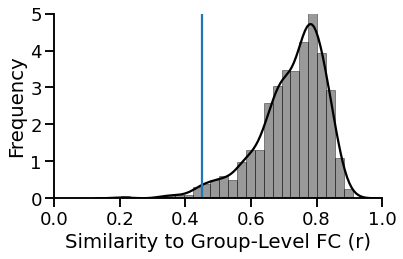

In [10]:
sns.set_context("talk", font_scale=1.1)
ax = sns.distplot(DF['CA'], 
                  hist_kws=dict(edgecolor="k", linewidth=1),
                  color='k')
sns.despine()
ax.set(xlim=(0,1))
ax.set(ylim=(0,5))
ax.set(ylabel='Frequency')
ax.set(xlabel='Similarity to Group-Level FC (r)')
plt.axvline(0.45, 0, 5)
plt.tight_layout()

## DG fc

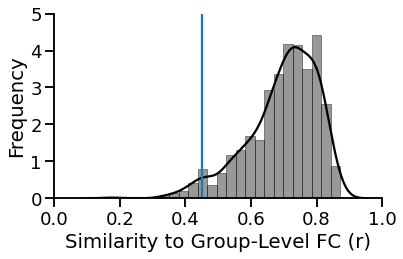

In [11]:
sns.set_context("talk", font_scale=1.1)
ax = sns.distplot(DF['DG'], 
                  hist_kws=dict(edgecolor="k", linewidth=1),
                  color='k')
sns.despine()
ax.set(xlim=(0,1))
ax.set(ylim=(0,5))
ax.set(ylabel='Frequency')
ax.set(xlabel='Similarity to Group-Level FC (r)')
plt.axvline(0.45, 0, 5)
plt.tight_layout()


## distribute t-values (of functional connectivity) and heritability scores into Yeo networks


In [12]:
yeo_L_file = '../data/tout_group/lh.Yeo2011_7Networks_N1000_32k.label.gii'
yeo_R_file = '../data/tout_group/rh.Yeo2011_7Networks_N1000_32k.label.gii'
yeo_L = nb.load(yeo_L_file).agg_data()
yeo_R = nb.load(yeo_R_file).agg_data()
yeo = np.concatenate((yeo_L, yeo_R))

yeo.shape

(64984,)

#### get surface info for plots

In [13]:
surf_lh, surf_rh = load_conte69()

# write surface coordinates and triangles in a dictionary
lh_coord = np.array(mesh_elements.get_points(surf_lh)).T
rh_coord = np.array(mesh_elements.get_points(surf_rh)).T
lh_tri = np.array(mesh_elements.get_cells(surf_lh))
rh_tri = np.array(mesh_elements.get_cells(surf_rh))

D = {}
D['coord'] = np.concatenate((lh_coord, rh_coord), axis=1)         # (3, 64984)     
D['tri'] = np.concatenate((lh_tri, rh_tri + lh_coord.shape[1]))   # (129960, 3)

# labeling
labeling_file = '../data/tout_group/glasser.csv' 
labeling = genfromtxt(labeling_file)

# medial wall mask
mask = labeling != 0 
mymask = np.ones((64984,)).astype('bool')
mymask[np.where(mask == False)[0]] = False
mymask[np.where(mask == False)[0] + 32492] = False


### SUB (left)

#### read T-values

In [14]:
fLSUB = '../data/tout_group/Tvals_cortex709_LSUB.h5'
h = h5py.File((fLSUB), 'r')
TdataLSUB = np.array(h['data'])
TLSUB = TdataLSUB.reshape(TdataLSUB.shape[1],)
print(TLSUB.shape)

(64984,)


In [15]:
# normalize the T-values (because H-values are all between 0 and 1)
TLSUBnorm = np.interp(TLSUB, (TLSUB.min(), TLSUB.max()), (0, 1))
TLSUBnorm[np.where(mymask == False)] = np.nan


#### read heritability scores

In [16]:
tot_node_num = 360
node_str = []
for i in range(1, tot_node_num+1):
    node_str.append(i)
print(len(node_str))
node_str[0], '...', node_str[-1]

fname = '../solar/cortex_LSUB/CLSUB_results_herit.txt'

data = pd.read_csv(fname,
                   index_col = 0,
                   header = 0)

data.index.name = 'node'

df_data_herit = pd.DataFrame(index = node_str,
                             columns = ['H2r', 'rp'])


for nodeID in range(1, tot_node_num + 1):

    iA = data.index.get_loc(nodeID)
    iB = df_data_herit.index.get_loc(nodeID)

    df_data_herit.iloc[iB]['H2r'] = data.iloc[iA]['H2r']
    df_data_herit.iloc[iB]['rp']  = data.iloc[iA]['rp']

360


In [17]:

H =  np.array(df_data_herit['H2r'], dtype = 'float')


In [18]:
# map H and p values to fsaverage
HSUB_labeled = map_to_labels(H, labeling, mask=mymask) 
HSUB_labeled_smo = mesh_smooth(HSUB_labeled.reshape(len(HSUB_labeled),1).T, D, 2)

HSUB_labeled[np.where(mymask == False)] = np.nan
HSUB_labeled_smo = HSUB_labeled_smo.reshape(HSUB_labeled_smo.shape[1],)
HSUB_labeled_smo[np.where(mymask == False)] = np.nan

HSUB_labeled.shape, np.nanmin(HSUB_labeled), np.nanmax(HSUB_labeled)

((64984,), 0.0322339, 0.49572879999999997)

In [19]:
# distribute T-values and heritability scores into 7 networks
df_LSUB = pd.DataFrame(index  = ['H', 'T'], 
                      columns = ['yeo1', 'yeo2', 'yeo3',
                                 'yeo4', 'yeo5', 'yeo6', 'yeo7'])

df_LSUB.at['T', 'yeo1'] = np.nanmean(TLSUBnorm[np.where(yeo==1)[0]])
df_LSUB.at['T', 'yeo2'] = np.nanmean(TLSUBnorm[np.where(yeo==2)[0]])
df_LSUB.at['T', 'yeo3'] = np.nanmean(TLSUBnorm[np.where(yeo==3)[0]])
df_LSUB.at['T', 'yeo4'] = np.nanmean(TLSUBnorm[np.where(yeo==4)[0]])
df_LSUB.at['T', 'yeo5'] = np.nanmean(TLSUBnorm[np.where(yeo==5)[0]])
df_LSUB.at['T', 'yeo6'] = np.nanmean(TLSUBnorm[np.where(yeo==6)[0]])
df_LSUB.at['T', 'yeo7'] = np.nanmean(TLSUBnorm[np.where(yeo==7)[0]])

df_LSUB.at['H', 'yeo1'] = np.nanmean(HSUB_labeled[np.where(yeo==1)[0]])
df_LSUB.at['H', 'yeo2'] = np.nanmean(HSUB_labeled[np.where(yeo==2)[0]])
df_LSUB.at['H', 'yeo3'] = np.nanmean(HSUB_labeled[np.where(yeo==3)[0]])
df_LSUB.at['H', 'yeo4'] = np.nanmean(HSUB_labeled[np.where(yeo==4)[0]])
df_LSUB.at['H', 'yeo5'] = np.nanmean(HSUB_labeled[np.where(yeo==5)[0]])
df_LSUB.at['H', 'yeo6'] = np.nanmean(HSUB_labeled[np.where(yeo==6)[0]])
df_LSUB.at['H', 'yeo7'] = np.nanmean(HSUB_labeled[np.where(yeo==7)[0]])

df_LSUB


,yeo1,yeo2,yeo3,yeo4,yeo5,yeo6,yeo7
H,0.258969,0.308922,0.219158,0.224734,0.238485,0.177307,0.286543
T,0.264297,0.283613,0.20145,0.143371,0.205047,0.176526,0.291657


In [20]:
print("VERTEX NUMBERS")
print("visual : ",  len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==1)])==False)),
      "  SMN : ",   len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==2)])==False)),
      "  DAN : ",   len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==3)])==False)),
      "  VAN : " ,  len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==4)])==False)),
      "  Limbic :", len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==5)])==False)),
      "  FPN: ",    len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==6)])==False)),
      "  DMN: ",    len(np.argwhere(np.isnan(TLSUBnorm[np.where(yeo==7)])==False)))



VERTEX NUMBERS
visual :  8629   SMN :  11702   DAN :  6913   VAN :  7270   Limbic : 4298   FPN:  7552   DMN:  12230


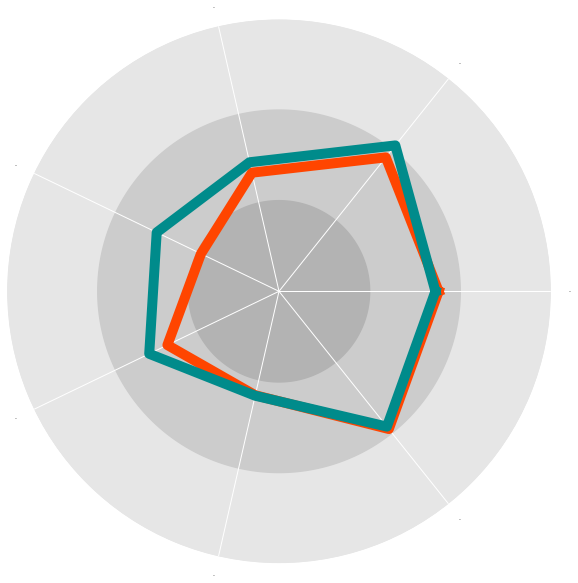

In [21]:
## Set data
dfA = pd.DataFrame({'group': df_LSUB.columns,
                   'var1':  df_LSUB.loc['T'],
                   'var2':  df_LSUB.loc['H'] })

fig = plot_funcs.make_spider_t_hvalues(dfA, 'var1', 'var2')


### CA (left)

#### read T-values

In [22]:
fLCA = '../data/tout_group/Tvals_cortex709_LCA.h5'

h = h5py.File((fLCA), 'r')
TdataLCA = np.array(h['data'])
TLCA = TdataLCA.reshape(TdataLCA.shape[1],)
print(TLCA.shape)

# normalize the T-values (because H-values are all between 0 and 1)
TLCAnorm = np.interp(TLCA, (TLCA.min(), TLCA.max()), (0, 1))
TLCAnorm[np.where(mymask == False)] = np.nan


(64984,)


#### read heritability scores


In [23]:
fname = '../solar/cortex_LCA/CLCA_results_herit.txt'
data = pd.read_csv(fname,
                   index_col = 0,
                   header = 0)
data.index.name = 'node'

df_data_herit = pd.DataFrame(index = node_str,
                             columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num + 1):

    iA = data.index.get_loc(nodeID)
    iB = df_data_herit.index.get_loc(nodeID)

    df_data_herit.iloc[iB]['H2r'] = data.iloc[iA]['H2r']
    df_data_herit.iloc[iB]['rp']  = data.iloc[iA]['rp']



In [24]:

H =  np.array(df_data_herit['H2r'], dtype = 'float')


In [25]:
HCA_labeled = map_to_labels(H, labeling, mask=mymask) 
HCA_labeled_smo = mesh_smooth(HCA_labeled.reshape(len(HCA_labeled),1).T, D, 2)
HCA_labeled_smo = HCA_labeled_smo.reshape(HCA_labeled_smo.shape[1],)

HCA_labeled[np.where(mymask == False)] = np.nan
HCA_labeled_smo[np.where(mymask == False)] = np.nan


HCA_labeled.shape, np.nanmin(HCA_labeled), np.nanmax(HCA_labeled)


((64984,), 0.06958500000000001, 0.5246314000000001)

In [26]:

# distribute T-values and heritability scores into 7 networks
df_LCA = pd.DataFrame(index  = ['H', 'T'], 
                      columns = ['yeo1', 'yeo2', 'yeo3',
                                 'yeo4', 'yeo5', 'yeo6', 'yeo7'])

df_LCA.at['T', 'yeo1'] = np.nanmean(TLCAnorm[np.where(yeo==1)[0]])
df_LCA.at['T', 'yeo2'] = np.nanmean(TLCAnorm[np.where(yeo==2)[0]])
df_LCA.at['T', 'yeo3'] = np.nanmean(TLCAnorm[np.where(yeo==3)[0]])
df_LCA.at['T', 'yeo4'] = np.nanmean(TLCAnorm[np.where(yeo==4)[0]])
df_LCA.at['T', 'yeo5'] = np.nanmean(TLCAnorm[np.where(yeo==5)[0]])
df_LCA.at['T', 'yeo6'] = np.nanmean(TLCAnorm[np.where(yeo==6)[0]])
df_LCA.at['T', 'yeo7'] = np.nanmean(TLCAnorm[np.where(yeo==7)[0]])

df_LCA.at['H', 'yeo1'] = np.nanmean(HCA_labeled[np.where(yeo==1)[0]])
df_LCA.at['H', 'yeo2'] = np.nanmean(HCA_labeled[np.where(yeo==2)[0]])
df_LCA.at['H', 'yeo3'] = np.nanmean(HCA_labeled[np.where(yeo==3)[0]])
df_LCA.at['H', 'yeo4'] = np.nanmean(HCA_labeled[np.where(yeo==4)[0]])
df_LCA.at['H', 'yeo5'] = np.nanmean(HCA_labeled[np.where(yeo==5)[0]])
df_LCA.at['H', 'yeo6'] = np.nanmean(HCA_labeled[np.where(yeo==6)[0]])
df_LCA.at['H', 'yeo7'] = np.nanmean(HCA_labeled[np.where(yeo==7)[0]])

df_LCA

,yeo1,yeo2,yeo3,yeo4,yeo5,yeo6,yeo7
H,0.311592,0.355812,0.302544,0.269003,0.273347,0.21707,0.305292
T,0.306381,0.344179,0.249005,0.183383,0.218682,0.199987,0.304225


In [27]:
print("VERTEX NUMBERS")
print("visual : ",  len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==1)])==False)),
      "  SMN : ",   len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==2)])==False)),
      "  DAN : ",   len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==3)])==False)),
      "  VAN : " ,  len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==4)])==False)),
      "  Limbic :", len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==5)])==False)),
      "  FPN: ",    len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==6)])==False)),
      "  DMN: ",    len(np.argwhere(np.isnan(TLCAnorm[np.where(yeo==7)])==False)))


VERTEX NUMBERS
visual :  8629   SMN :  11702   DAN :  6913   VAN :  7270   Limbic : 4298   FPN:  7552   DMN:  12230


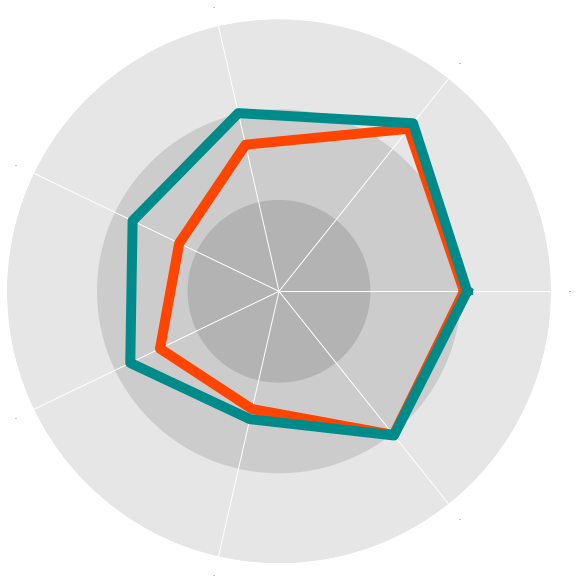

In [28]:
dfB = pd.DataFrame({'group': df_LCA.columns,
                   'var1':  df_LCA.loc['T'],
                   'var2':  df_LCA.loc['H'] })

fig = plot_funcs.make_spider_t_hvalues(dfB, 'var1', 'var2')



### DG (left)

#### read T-values

In [29]:
fLDG = '../data/tout_group/Tvals_cortex709_LDG.h5'

h = h5py.File((fLDG), 'r')
TdataLDG = np.array(h['data'])
TLDG = TdataLDG.reshape(TdataLDG.shape[1],)
print(TLDG.shape)

# normalize the T-values (because H-values are all between 0 and 1)
TLDGnorm = np.interp(TLDG, (TLDG.min(), TLDG.max()), (0, 1))
TLDGnorm[np.where(mymask == False)] = np.nan


(64984,)


#### read heritability scores

In [30]:
fname = '../solar/cortex_LDG/CLDG_results_herit.txt'

data = pd.read_csv(fname,
                   index_col = 0,
                   header = 0)

data.index.name = 'node'
df_data_herit = pd.DataFrame(index = node_str,
                             columns = ['H2r', 'rp'])

for nodeID in range(1, tot_node_num + 1):

    iA = data.index.get_loc(nodeID)
    iB = df_data_herit.index.get_loc(nodeID)

    df_data_herit.iloc[iB]['H2r'] = data.iloc[iA]['H2r']
    df_data_herit.iloc[iB]['rp']  = data.iloc[iA]['rp']


In [31]:

H =  np.array(df_data_herit['H2r'], dtype = 'float')


In [32]:
HDG_labeled = map_to_labels(H, labeling, mask=mymask) 
HDG_labeled_smo = mesh_smooth(HDG_labeled.reshape(len(HDG_labeled),1).T, D, 2)
HDG_labeled_smo = HDG_labeled_smo.reshape(HDG_labeled_smo.shape[1],)

HDG_labeled[np.where(mymask == False)] = np.nan
HDG_labeled_smo[np.where(mymask == False)] = np.nan

HDG_labeled.shape, np.nanmin(HDG_labeled), np.nanmax(HDG_labeled)


((64984,), 0.0634892, 0.5007803)

In [33]:
# distribute T-values and heritability scores into 7 networks
df_LDG = pd.DataFrame(index  = ['H', 'T'], 
                      columns = ['yeo1', 'yeo2', 'yeo3',
                                 'yeo4', 'yeo5', 'yeo6', 'yeo7'])

df_LDG.at['T', 'yeo1'] = np.nanmean(TLDGnorm[np.where(yeo==1)[0]])
df_LDG.at['T', 'yeo2'] = np.nanmean(TLDGnorm[np.where(yeo==2)[0]])
df_LDG.at['T', 'yeo3'] = np.nanmean(TLDGnorm[np.where(yeo==3)[0]])
df_LDG.at['T', 'yeo4'] = np.nanmean(TLDGnorm[np.where(yeo==4)[0]])
df_LDG.at['T', 'yeo5'] = np.nanmean(TLDGnorm[np.where(yeo==5)[0]])
df_LDG.at['T', 'yeo6'] = np.nanmean(TLDGnorm[np.where(yeo==6)[0]])
df_LDG.at['T', 'yeo7'] = np.nanmean(TLDGnorm[np.where(yeo==7)[0]])

df_LDG.at['H', 'yeo1'] = np.nanmean(HDG_labeled[np.where(yeo==1)[0]])
df_LDG.at['H', 'yeo2'] = np.nanmean(HDG_labeled[np.where(yeo==2)[0]])
df_LDG.at['H', 'yeo3'] = np.nanmean(HDG_labeled[np.where(yeo==3)[0]])
df_LDG.at['H', 'yeo4'] = np.nanmean(HDG_labeled[np.where(yeo==4)[0]])
df_LDG.at['H', 'yeo5'] = np.nanmean(HDG_labeled[np.where(yeo==5)[0]])
df_LDG.at['H', 'yeo6'] = np.nanmean(HDG_labeled[np.where(yeo==6)[0]])
df_LDG.at['H', 'yeo7'] = np.nanmean(HDG_labeled[np.where(yeo==7)[0]])

df_LDG

,yeo1,yeo2,yeo3,yeo4,yeo5,yeo6,yeo7
H,0.298572,0.400951,0.312358,0.290602,0.271738,0.244166,0.290163
T,0.277065,0.29829,0.230168,0.182671,0.190748,0.197147,0.266255


In [34]:
print("VERTEX NUMBERS")
print("visual : ",  len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==1)])==False)),
      "  SMN : ",   len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==2)])==False)),
      "  DAN : ",   len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==3)])==False)),
      "  VAN : " ,  len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==4)])==False)),
      "  Limbic :", len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==5)])==False)),
      "  FPN: ",    len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==6)])==False)),
      "  DMN: ",    len(np.argwhere(np.isnan(TLDGnorm[np.where(yeo==7)])==False)))


VERTEX NUMBERS
visual :  8629   SMN :  11702   DAN :  6913   VAN :  7270   Limbic : 4298   FPN:  7552   DMN:  12230


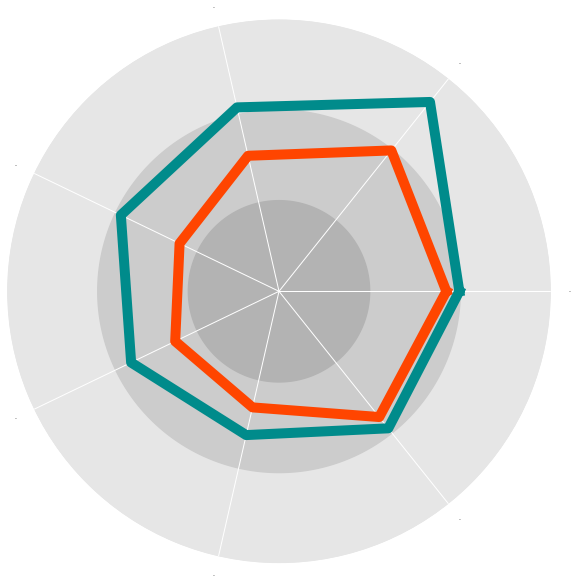

In [35]:
dfC = pd.DataFrame({'group': df_LDG.columns,
                   'var1':  df_LDG.loc['T'],
                   'var2':  df_LDG.loc['H'] })

fig = plot_funcs.make_spider_t_hvalues(dfC, 'var1', 'var2')
